# Setup and data cleaning

In [277]:
# Dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [315]:
# Import IMDB movie data
title_basics = pd.read_csv('../data/title.basics.tsv',delimiter='\t',encoding='utf-8-sig', low_memory=False)

# Import ratings
title_ratings = pd.read_csv('../data/title.ratings.tsv',delimiter='\t',encoding='utf-8-sig')

# Import crew
title_crew = pd.read_csv('../data/title.crew.tsv',delimiter='\t',encoding='utf-8-sig')

# Import name basics
name_basics = pd.read_csv('../data/name.basics.tsv',delimiter='\t',encoding='utf-8-sig')

# Import box office data from BoxOfficeMojo
box_office = pd.read_csv('../data/boxoffice.csv')

# Import Oscar data from Wikipedia: https://en.wikipedia.org/wiki/List_of_Academy_Award-winning_films
oscars = pd.read_csv('../data/oscars_cleaned.csv')

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 0-1: malformed \N character escape (<ipython-input-315-e02f468a9b43>, line 2)

In [120]:
# Filter non-movies, adult movies
title_filtered = title_basics[title_basics['titleType']=='movie']
title_filtered = title_filtered[title_filtered['isAdult']==0]

In [129]:
# Split out genres and join
genres_split = title_filtered["genres"].str.split(",", n=2, expand=True)
joined = title_filtered.join(genres_split)

In [131]:
# Rename and drop some columns
cleaned = joined.rename(columns = {'tconst':'IMDB ID', 'titleType': 'Type', 'primaryTitle': 'Title', 'originalTitle': 'Title (original)', 'startYear': 'Year', 'runtimeMinutes': 'Runtime (min)', 0:'Genre (main)', 1:'Genre (sub 1)', 2:'Genre (sub 2)'})
cleaned = cleaned.drop(columns=['endYear', 'genres', 'Genre (sub 1)', 'Genre (sub 2)', 'Title (original)'])

In [ ]:
#cleaned = cleaned.dropna(axis='rows')

In [349]:
# Merge basic set and rating
with_ratings = cleaned.set_index('IMDB ID').join(title_ratings.set_index('tconst'))
with_ratings = with_ratings.rename(columns = {'averageRating': 'Rating (avg.)', 'numVotes': 'Votes'})

# Merge box office and Oscars
merged = pd.merge(box_office, oscars, left_on='title', right_on='Film', how='outer')

In [350]:
# Merge both of above to make combined set
combined = with_ratings.merge(merged,how='left', left_on='Title', right_on='title')

In [351]:
# Drop, rename
combined = combined.drop(['Type', 'isAdult', 'Year_y', 'year', 'rank', 'title', 'Film'], axis=1)
combined = combined.rename(columns = {'Year_x': 'Year', 'studio': 'Studio', 'lifetime_gross': 'Gross (lifetime)'})

In [352]:
combined.count()

Title               540781
Year                540781
Runtime (min)       540781
Genre (main)        540781
Rating (avg.)       243681
Votes               243681
Studio               27293
Gross (lifetime)     27357
Awards                1312
Nominations           1312
dtype: int64

## More data etc. we could integrate

In [ ]:
# https://towardsdatascience.com/collecting-movie-data-445ca1ead8e5
# Budget
# Country (e.g. most popular genres by country)

# Calculate avg gross ($) per movie
#box_plot['Avg. lifetime gross'] = box_plot['lifetime_gross']/box_plot['title']

# Reset index to get year in column
#box_plot.reset_index()

# Machine Learning [WIP]

In [347]:
#https://stackoverflow.com/questions/52294941/python-filter-a-list-remove-n-and-empty-string
# Condense data set, removing NaN
#combined_filtered = combined[combined['Runtime (min)']==20]
# combined = combined['Runtime (min)'].replace("\n", " ")

In [348]:
combined.head()

0     45
1     20
2     \N
3    100
4     70
Name: Runtime (min), dtype: object

In [340]:
condensed = combined.dropna(axis='rows')
condensed.head()

,Title,Year,Runtime (min),Genre (main),Rating (avg.),Votes,Studio,Gross (lifetime),Awards,Nominations
415,Anna Karenina,1914,\N,Drama,5.6,14.0,Focus,12816367.0,1.0,4.0
902,Anna Karenina,1915,\N,Drama,4.3,7.0,Focus,12816367.0,1.0,4.0
2124,The Patriot,1916,50,Western,7.4,8.0,Sony,113330342.0,1.0,5.0
2701,Great Expectations,1917,50,Drama,5.8,16.0,Fox,26420672.0,2.0,5.0
3306,Anna Karenina,1918,53,Drama,5.3,18.0,Focus,12816367.0,1.0,4.0


In [298]:
# Assign data to x, y
# Note: Sklearn requires a two-dimensional array of values so we use reshape to create this
x = combined['Year'].values.reshape(-1, 1)
y = combined['Runtime (min)'].values.reshape(-1, 1)
print("Shape: ", x.shape, y.shape)

Shape:  (540781, 1) (540781, 1)


In [300]:
y

array([['45'],
       ['20'],
       ['\\N'],
       ...,
       ['\\N'],
       ['116'],
       ['49']], dtype=object)

TypeError: unhashable type: 'numpy.ndarray'

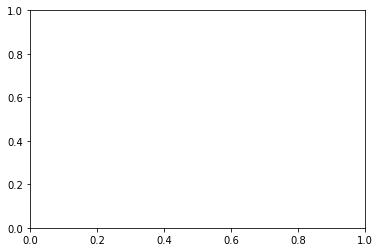

In [297]:
# FIX https://datascience.stackexchange.com/questions/39831/typeerror-unhashable-type-numpy-ndarray

# Plot the data to see if a linear trend exists
plt.scatter(x, y)
plt.xlabel('Year')
plt.ylabel('Runtime (min)')

In [288]:
# Use sklearn's `train_test_split` to split the data into training and testing
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

In [289]:
# Create the model
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [293]:
# Fit model to training data. Ccalculate scores for training and testing data
model.fit(x_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# Calculate mean_squared_error and r-squared value for testing data
from sklearn.metrics import mean_squared_error, r2_score

# Use our model to make predictions
predicted = model.predict(x_test)

# Score the predictions with mse and r2
mse = mean_squared_error(y_test, predicted)
r2 = r2_score(y_test, predicted)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2 ): {r2}")

#training_score = model.score(x_train, y_train)
#testing_score = model.score(x_test, y_test)

#print(f"Training Score: {training_score}")
#print(f"Testing Score: {testing_score}")

In [ ]:
# Call the `score` method on the model to show the r2 score
model.score(x_test, y_test)

In [ ]:
# Plot the Residuals for the Training and Testing data
#plt.scatter(model.predict(x_train), model.predict(x_train) - y_train, c="blue", label="Training Data")
#plt.scatter(model.predict(x_test), model.predict(x_test) - y_test, c="orange", label="Testing Data")
#plt.legend()
#plt.hlines(y=0, xmin=y.min(), xmax=y.max())
#plt.title("Residual Plot")